# Calculo de irradiancia promedio diaria y HSP

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

### Introducir la ubicación en grados, y la fecha en el formato YYYYMMDD

In [2]:
latitude = 21
longitude = -89
start_date = "20200101"
end_date = "20250101"
parameter = "ALLSKY_SFC_SW_DWN"

In [3]:
url = (
    f"https://power.larc.nasa.gov/api/temporal/hourly/point?"
    f"start={start_date}&end={end_date}"
    f"&latitude={latitude}&longitude={longitude}"
    f"&community=SB&parameters={parameter}"
    f"&format=json&units=metric"
)

In [4]:
response = requests.get(url)
data = response.json()

In [5]:
irradiance_data = data['properties']['parameter'][parameter]
df = pd.DataFrame.from_dict(irradiance_data, orient='index', columns=["Irradiancia_W_m2"])
df.index = pd.to_datetime(df.index, format="%Y%m%d%H")
df.to_csv("irradiancia_bdd.csv", index_label="FechaHora", encoding="utf-8")


### Grafica de irradiancia solar según el tiempo indicado

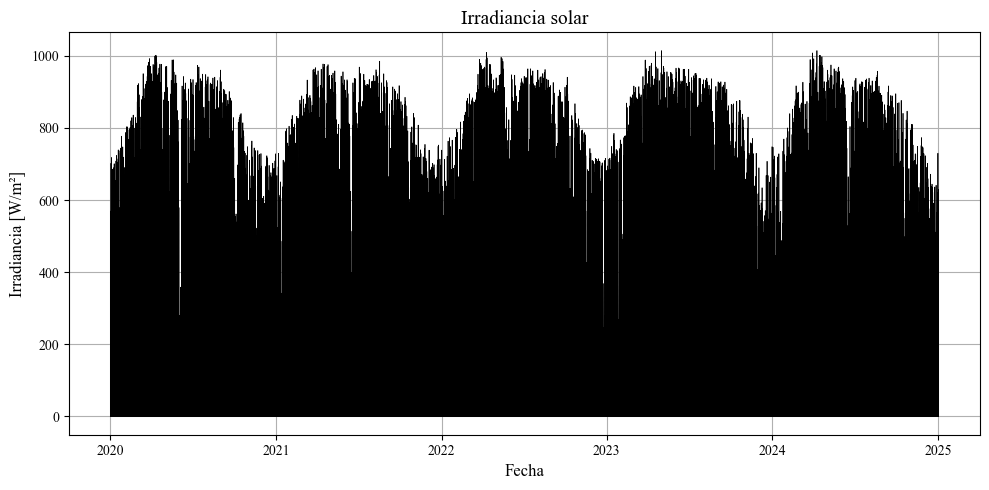

In [6]:
plt.rcParams["font.family"] = "Times New Roman"
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.index, df["Irradiancia_W_m2"], linewidth=0.5, color='black')
ax.set_title("Irradiancia solar", fontsize=14)
ax.set_xlabel("Fecha", fontsize=12)
ax.set_ylabel("Irradiancia [W/m²]", fontsize=12)
ax.tick_params(axis='both', labelsize=10)
ax.grid(True)
fig.tight_layout()
fig.savefig("irradiancia_promedio_solar.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
print(df.describe())
print(df.isnull().sum())

       Irradiancia_W_m2
count      43872.000000
mean         229.344496
std          304.896919
min            0.000000
25%            0.000000
50%            7.985000
75%          479.042500
max         1014.280000
Irradiancia_W_m2    0
dtype: int64


In [8]:
df['hour'] = df.index.hour
hourly_mean = df.groupby('hour')['Irradiancia_W_m2'].mean()
print(hourly_mean)

hour
0       0.000000
1       0.000000
2       0.000000
3       0.000000
4       0.000000
5       5.043682
6      81.312921
7     254.619836
8     454.971548
9     621.040881
10    723.861947
11    774.360405
12    755.272620
13    673.927702
14    544.257511
15    369.957801
16    192.219628
17     51.203900
18      2.217516
19      0.000000
20      0.000000
21      0.000000
22      0.000000
23      0.000000
Name: Irradiancia_W_m2, dtype: float64


In [9]:
daily_sum = df['Irradiancia_W_m2'].resample('D').sum()
daily_mean = daily_sum.mean()
hsp = daily_mean / 1000
print("Promedio de irradiancia diaria:", daily_mean, "Wh/m²")
print("Horas pico solares promedio (HSP/día):", hsp)

Promedio de irradiancia diaria: 5504.267899343546 Wh/m²
Horas pico solares promedio (HSP/día): 5.504267899343546


## Grafica de irradiancia promedio diaria

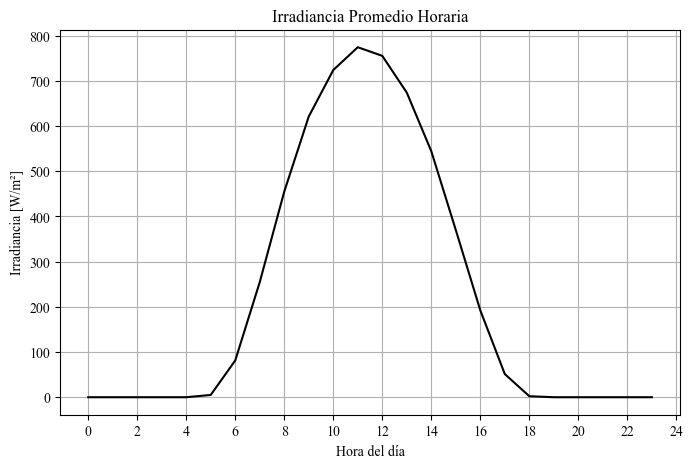

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(hourly_mean.index, hourly_mean.values, linestyle='-', color='black')
ax.set_title("Irradiancia Promedio Horaria")
ax.set_xlabel("Hora del día")
ax.set_ylabel("Irradiancia [W/m²]")
ax.set_xticks(range(0, 25, 2))
ax.grid(True)
fig.savefig("irradiancia_promedio_diaria.png", dpi=300, bbox_inches='tight')
plt.show()

## Grafica de HSP

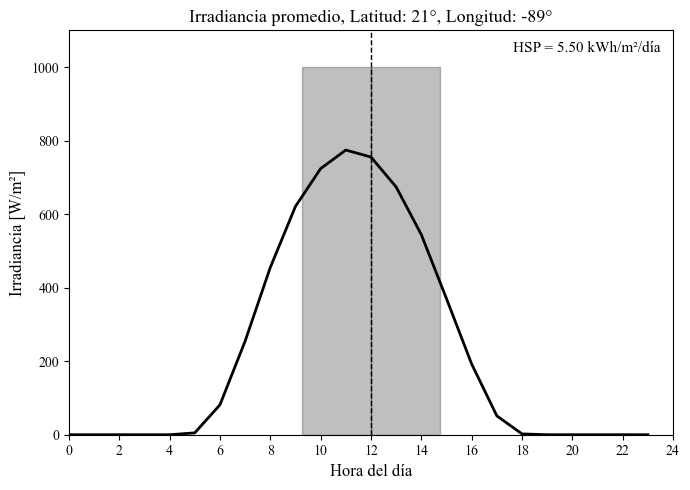

In [11]:
hourly_mean = df.groupby(df.index.hour)['Irradiancia_W_m2'].mean().reindex(range(24), fill_value=0)
daily_sum  = df['Irradiancia_W_m2'].resample('D').sum()
daily_mean = daily_sum.mean()
hsp = daily_mean / 1000.0
h2  = hsp / 2.0
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(hourly_mean.index, hourly_mean.values, linewidth=2, color='black')
left_x0  = max(0, 12 - h2)
left_w   = min(h2, 12 - left_x0)
right_x0 = 12
right_w  = min(h2, 24 - right_x0)
ax.add_patch(Rectangle((left_x0, 0),  left_w, 1000, alpha=0.25, color='black'))
ax.add_patch(Rectangle((right_x0, 0), right_w, 1000, alpha=0.25, color='black'))
ax.axvline(12, linestyle='--', linewidth=1, color='black')
ax.text(23.5, 1070, f"HSP = {hsp:.2f} kWh/m²/día", ha='right', va='top', fontsize=11, color='black', fontname='Times New Roman')
ax.set_xlim(0, 24)
ax.set_ylim(0, max(1100, hourly_mean.max()*1.1))
ax.set_xticks(range(0, 25, 2))
ax.set_xlabel("Hora del día", fontsize=12, color='black')
ax.set_ylabel("Irradiancia [W/m²]", fontsize=12, color='black')
ax.set_title(f"Irradiancia promedio, Latitud: {latitude}°, Longitud: {longitude}°", fontsize=13, color='black')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontname('Times New Roman')
    label.set_color('black')

plt.tight_layout()
fig.savefig("HSP.png", dpi=300, bbox_inches='tight')
plt.show()